# Learning Lorenz System Dynamics

## 1. Imports

In [1]:
import os
import sys

import torch
import torch.optim as optim

# add parent directory to "sys.path" to import modules from that path
sys.path.append(os.path.normpath(os.path.join(os.getcwd(), os.pardir)))

from data_generation.data_generator import DataGenerator
from dynamic_systems.lorenz_system import LorenzSystem
from nn_models.simple_rnn import SimpleRNN
from nn_models.simple_lstm import SimpleLSTM
from nn_models.simple_gru import SimpleGRU
from testing.tester import Tester
from training.trainer import Trainer

## 2. Dynamic System

### 2.1 Dynamic System Description

The Lorenz system is a set of three nonlinear differential equations originally developed by Edward Lorenz to model atmospheric convection. This system is famous for its chaotic behavior and is often used as an example of a deterministic chaotic system.

The Lorenz system consists of three coupled, first-order, nonlinear differential equations:

$$\dot{x} = \sigma (y - x)$$
$$\dot{y} = x (\rho - z) - y$$
$$\dot{z} = x y - \beta z$$

where:

- $\sigma$ is the Prandtl number, a parameter representing the ratio of momentum diffusivity (viscosity) to thermal diffusivity.
- $\rho$ is the Rayleigh number, which represents the difference in temperature driving the convection.
- $\beta$ is a geometric factor related to the physical dimensions of the system.

### 2.2 Dynamic System Definition

The `LorenzSystem` class is used to instantiate a dynamic system object representing the Lorenz System model.

In [2]:
dynamic_system_model = LorenzSystem(
    sigma=10,
    rho=28,
    beta=8/3,
)

### 2.3 Dynamic System Simulation

The `simulate_system` method is used to to simulate the behavior of the system by numerically integrating the differential equations that govern its dynamics over a specified time horizon.

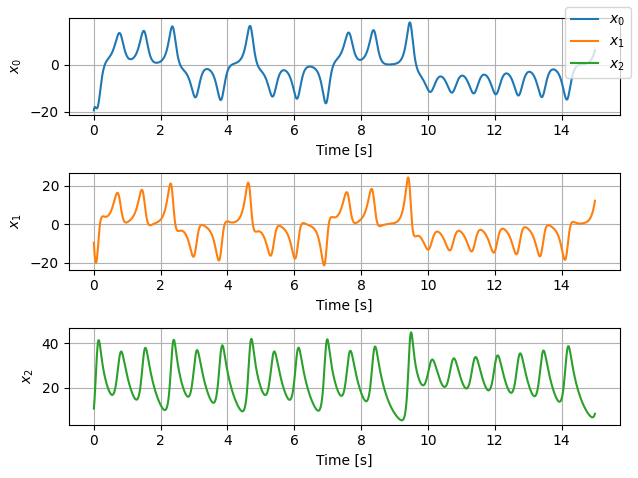

In [3]:
# define timing parameters
time_horizon = 15
integration_step = 0.01

# simulate system
dynamic_system_model.simulate_system(
    time_horizon=time_horizon,
    integration_step=integration_step,
    initial_state=None
)

## 3. Datasets Generation

To train neural networks to accurately predict the dynamics of the Lorenz System, we first need to construct a comprehensive dataset that captures the system's behavior over time. This task is addressed by the `DataGenerator` class, which is designed to generate time series data capturing the system's behavior over time.

The `DataGenerator` class collects the states of the system over several simulations which can be used to create:

- TensorDataset objects used during training and validation phases
- Dictionaries of numpy arrays used during testing phases


In [4]:
# define timing parameters
time_horizon = 15
integration_step = 0.01

# define data generator object
data_generator = DataGenerator(
    dynamic_system=dynamic_system_model,
    time_horizon=time_horizon,
    integration_step=integration_step,
)

### 3.1 Training Dataset

The `generate_dataset` method is used to generate both training and validation datasets by specifying the number of observations $N$ and the observation window $T_x$.

The resulting TensorDataset object contains $N$ training examples divided into inputs $X$ and outputs $Y$.

Each input is represented by the sequence $x^{<t>}, x^{<t+1>}, x^{<t+2>}, \ldots , x^{<t+T_x>}$ where $x^{t+k}$ represents the state of the dynamic system at time $t+k$.

The output $y$ represents the system state at time $t+T_x+1$.

The objective is to train the Neural Network to predict the state $x^{t+T_x+1}$ given the input sequence $x^{<t>}, x^{<t+1>}, x^{<t+2>}, \ldots , x^{<t+T_x>}$.


In [5]:
# define the observation window
observation_window = 100

# generate training dataset
training_data = data_generator.generate_dataset(
    obs_num=500000,
    obs_window=observation_window,
    batch_size=128,
    shuffle=True,
)

Dataset generation started...
- Simulation process started...
- Simulation process completed. Total simulations: 357
- Data aggregation started...
- Data aggregation completed.
Dataset generation completed.


### 3.2 Validation Dataset

In [6]:
# generate validation dataset
validation_data = data_generator.generate_dataset(
    obs_num=50000,
    obs_window=observation_window,
    batch_size=128,
    shuffle=True,
)

Dataset generation started...
- Simulation process started...
- Simulation process completed. Total simulations: 36
- Data aggregation started...
- Data aggregation completed.
Dataset generation completed.


## 4. Neural Network Model

### 4.1 Model definition

RNNs, or Recurrent Neural Networks, are a type of artificial neural network designed to process sequential data by incorporating loops within the network architecture, allowing information to persist over time.

LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) are RNNs architectures designed to overcome the vanishing gradient problem in traditional RNNs and capture long-range dependencies in sequential data. LSTM utilizes memory cells and gate mechanisms to control the flow of information, while GRU simplifies this architecture by merging the forget and input gates.

In [7]:
# define RNN parameters
input_size = dynamic_system_model.state_dim
output_size = input_size

# define NN model (uncomment the model you want to use)
# nn_model = SimpleRNN(input_size=input_size, hidden_size=64, output_size=output_size, num_layers=1)
nn_model = SimpleLSTM(input_size=input_size, hidden_size=64, output_size=output_size, num_layers=2)
# nn_model = SimpleGRU(input_size=input_size, hidden_size=64, output_size=output_size, num_layers=1)

### 4.2 Optimization algorithm and Loss function

Before start training the NN model it is needed to select the optimization algorithm and the loss function.

Adam is a popular optimization algorithm used in training neural networks. It combines the benefits of both AdaGrad and RMSProp, utilizing adaptive learning rates and momentum to efficiently navigate the optimization landscape and converge to an optimal solution.

MSE, or Mean Squared Error, is a commonly used loss function in regression tasks. It calculates the average squared difference between the predicted and actual values, providing a measure of the model's performance by penalizing larger deviations more heavily.

In [8]:
# define optimizer and loss function
optimizer = optim.Adam(nn_model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_function = torch.nn.MSELoss()

## 5. NN Model Training and Validation

### 5.1 Trainer definition

Once you have generated the datasets and selected the NN model along with the optimization algorithm and the loss funciton, you can proceed with training and validate the NN model to learn the dynamics of the system using the `Trainer` class.

This class provides the `train_model` method to manage training and validation loops, which involve iteratively feeding batches of data from the dataset into the neural network models, computing predictions, calculating the loss, and updating the model parameters to minimize the loss through backpropagation.

In [9]:
# define number of training epochs
epochs_num = 20

# define trainer object
trainer = Trainer(
    nn_model=nn_model,
    optimizer=optimizer,
    loss_function=loss_function,
    dynamic_system_tag=dynamic_system_model.tag,
    epochs_num=epochs_num,
    validate_model=True,
)

# train NN model
trainer.train_model(
    training_dataloader=training_data,
    validation_dataloader=validation_data,
)

# save NN model
trainer.save_nn_model()

----------------------------------------------------------------------------
| Start training and validation of SimpleLSTM model on LorenzSystem system |
----------------------------------------------------------------------------
- Epoch: 1 | Training loss: 90.95114 | Validation loss: 29.86995
- Epoch: 2 | Training loss: 11.99327 | Validation loss: 3.80378
- Epoch: 3 | Training loss: 1.27783 | Validation loss: 0.30051
- Epoch: 4 | Training loss: 0.09859 | Validation loss: 0.02059
- Epoch: 5 | Training loss: 0.0078 | Validation loss: 0.00273
- Epoch: 6 | Training loss: 0.00149 | Validation loss: 0.00098
- Epoch: 7 | Training loss: 0.00081 | Validation loss: 0.00081
- Epoch: 8 | Training loss: 0.0006 | Validation loss: 0.00072
- Epoch: 9 | Training loss: 0.00047 | Validation loss: 0.00036
- Epoch: 10 | Training loss: 0.00044 | Validation loss: 0.00028
- Epoch: 11 | Training loss: 0.00038 | Validation loss: 0.00038
- Epoch: 12 | Training loss: 0.00034 | Validation loss: 0.00029
- Epoch: 

## 6. NN Model Testing

At this point it is possible to evaluate the NN model predictions on new time series data.

This process is managed by the `Tester` class, which facilitates the evaluation by systematically testing the trained model's performance on unseen data.

For the first prediction step the input sequence is $x^{<0>}, x^{<1>}, x^{<2>}, \ldots , x^{<T_x>}$, then the NN model estimate the state $\hat{x}^{T_x+1}$.

The input sequence for the second estimation step is $x^{<1>}, x^{<2>}, x^{<3>}, \ldots , x^{<T_x>}, \hat{x}^{T_x+1}$ and it is used to predict the state $\hat{x}^{T_x+2}$.

This process continues iteratively. Each new prediction step shifts the input sequence forward and incorporates the latest predicted state. As the number of prediction steps increases, the input sequences gradually consist more of estimated states rather than actual observed ones. This accumulation of estimation errors leads to a decrease in the model's prediction accuracy over time.

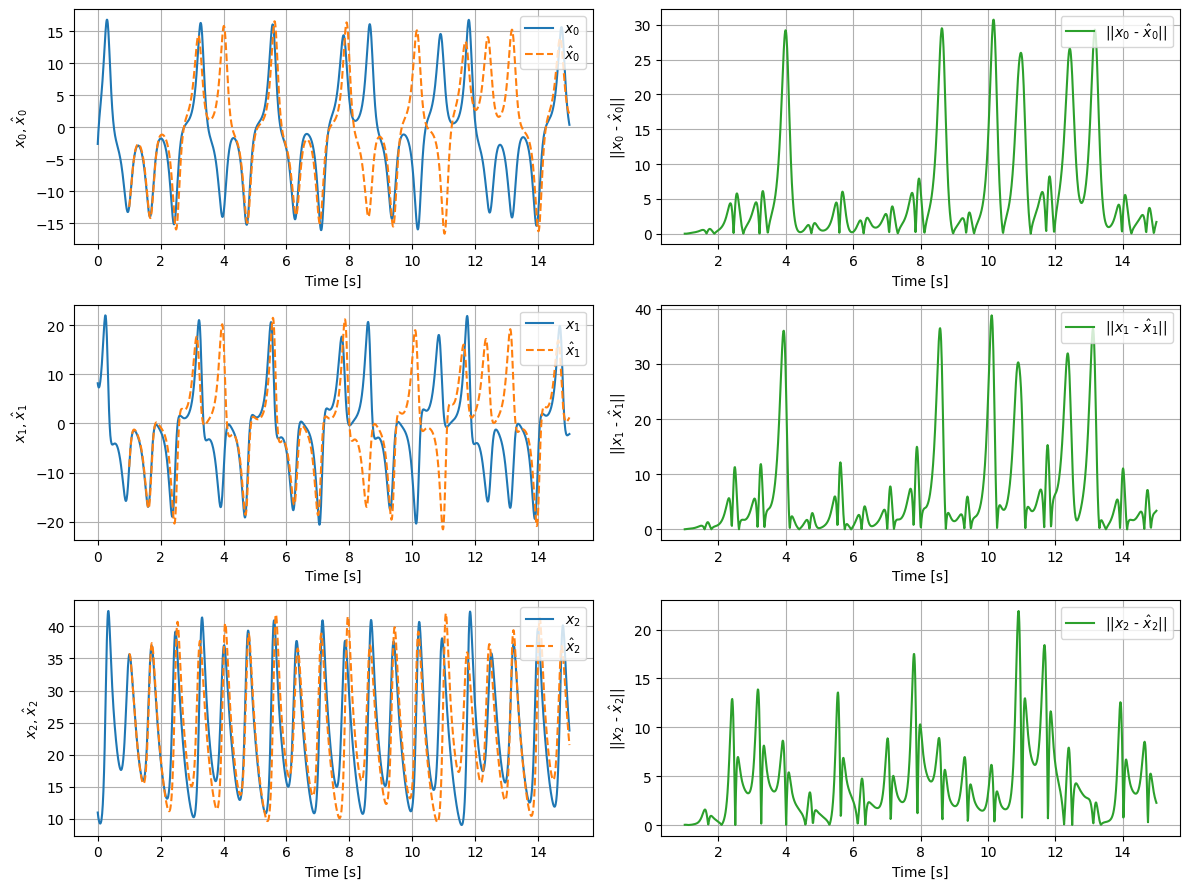

In [24]:
# generate new time series data
time_series = data_generator.generate_timeseries(initial_state=None)

# define tester object
tester = Tester(time_series=time_series, obs_window=observation_window, nn_model=nn_model)

# uncomment the following line to load saved model
# tester.load_model()

# test trained NN model on new time series data
tester.test_model()
tester.plot_results()